In [4]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd

!pip install pyfolio
import pyfolio as pf
import scipy.optimize as sco

HW 3

In [5]:
RISKY_ASSETS = ['AAPL','IBM','MSFT']
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
n_assets = len(RISKY_ASSETS)

In [6]:
prices_df = yf.download(RISKY_ASSETS, start=START_DATE,
                       end=END_DATE, adjusted=True)
print(f'Download {prices_df.shape[0]} rows of data.')
N_DAYS=len(prices_df)

[*********************100%***********************]  3 of 3 completed
Download 250 rows of data.


In [7]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [8]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
  portf_returns = np.sum(avg_rtns * w)
  portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
  portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
  return -portf_sharpe_ratio

def portf_vol(w, avg_rtns, cov_mat, rf_rate):
  portf_volatility = np. sqrt(np.dot(w.T, np.dot(cov_mat, w)))
  return portf_volatility

In [9]:
n_assets = len(avg_returns)
RF_RATE = 0

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq',
                'fun': lambda x: np.sum(x)-1})

bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio,
                                x0=initial_guess,
                                args=args,
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints)
min_vol_portf = sco.minimize(portf_vol,
                             x0=initial_guess,
                             args=args,
                             method='SLSQP',
                             bounds=bounds,
                             constraints=constraints)

1.

In [10]:
max_sharpe_portf

     fun: -0.7537896492742012
     jac: array([ 6.83071166e-01,  1.22896954e+00, -7.45058060e-09])
 message: 'Optimization terminated successfully'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([1.11022302e-16, 0.00000000e+00, 1.00000000e+00])

In [11]:
max_sharpe_portf.x

array([1.11022302e-16, 0.00000000e+00, 1.00000000e+00])

2.

In [12]:
min_vol_portf

     fun: 0.22490609491776653
     jac: array([0.22489811, 0.22491228, 0.22489551])
 message: 'Optimization terminated successfully'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.27957416, 0.58789945, 0.13252638])

In [13]:
min_vol_portf.x

array([0.27957416, 0.58789945, 0.13252638])

HW4

In [14]:
import scipy
import scipy.linalg

In [15]:
T = 1
N = len(returns_df)
N_SIM = 10**3

In [16]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
  
    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

1.

In [17]:
shares_1=max_sharpe_portf.x

In [18]:
mu=np.matmul(avg_returns,shares_1)
sigma=np.matmul(np.matmul(shares_1,cov_mat.values),shares_1.T)

In [19]:
gbm_simulations = simulate_gbm(1, mu, sigma, N_SIM, T, N)

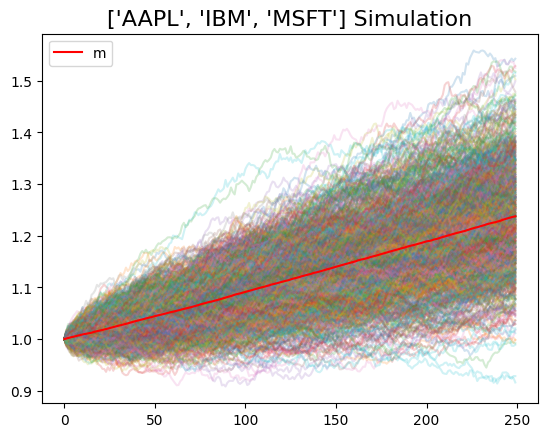

In [20]:
plot_title = (f'{RISKY_ASSETS} Simulation')

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1 = ax.plot(gbm_simulations_df.mean(axis=1),
                 color='red')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1), ('mean'))

2.

In [21]:
shares_2=min_vol_portf.x

In [22]:
mu=np.matmul(avg_returns,shares_2)
sigma=np.matmul(np.matmul(shares_2,cov_mat.values),shares_2.T)

In [23]:
gbm_simulations = simulate_gbm(1, mu, sigma, N_SIM, T, N)

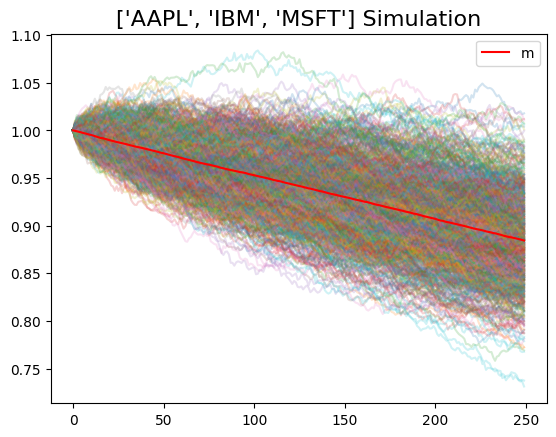

In [24]:
plot_title = (f'{RISKY_ASSETS} Simulation')

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations))

ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1 = ax.plot(gbm_simulations_df.mean(axis=1),
                 color='red')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1), ('mean'))